In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale


In [2]:
image = cv2.imread('Aslam.jpg', 0)


In [3]:

# Apply DFT and shift the zero frequency component to the center
dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)


In [4]:

# Bandpass Filter Function
def create_bandpass_filter(shape, low, high):
    rows, cols = shape
    crow, ccol = rows // 2 , cols // 2
    
    mask = np.zeros((rows, cols, 2), np.uint8)
    
    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i - crow)**2 + (j - ccol)**2)
            if low < d < high:
                mask[i, j] = 1
    
    return mask


In [5]:

# Bandreject Filter Function
def create_bandreject_filter(shape, low, high):
    rows, cols = shape
    crow, ccol = rows // 2 , cols // 2
    
    mask = np.ones((rows, cols, 2), np.uint8)
    
    for i in range(rows):
        for j in range(cols):
            d = np.sqrt((i - crow)**2 + (j - ccol)**2)
            if low < d < high:
                mask[i, j] = 0
    
    return mask


In [6]:

# Notch Filter Function
def create_notch_filter(shape, center, radius):
    rows, cols = shape
    mask = np.ones((rows, cols, 2), np.uint8)
    
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - center[0])**2 + (j - center[1])**2) <= radius:
                mask[i, j] = 0
    
    return mask


In [7]:
# Create filters
low_cutoff = 30
high_cutoff = 100
bandpass_filter = create_bandpass_filter(image.shape, low_cutoff, high_cutoff)
bandreject_filter = create_bandreject_filter(image.shape, low_cutoff, high_cutoff)
notch_center = (image.shape[0] // 2 + 50, image.shape[1] // 2 + 50)
notch_radius = 20
notch_filter = create_notch_filter(image.shape, notch_center, notch_radius)


In [8]:

# Apply the Bandpass Filter
fshift_bandpass_filtered = dft_shift * bandpass_filter

# Apply the Bandreject Filter
fshift_bandreject_filtered = dft_shift * bandreject_filter

# Apply the Notch Filter
fshift_notch_filtered = dft_shift * notch_filter


In [31]:
# Inverse Filtering (example with a simple degradation function)
H = np.abs(dft_shift)  # Replace with actual degradation function
inverse_filter = 1 / (H+1e-5)
fshift_inverse_filtered = dft_shift * inverse_filter


In [32]:
# Wiener Filtering
K = 0.001
wiener_filter = np.conj(H) / (H**2 + K)
fshift_wiener_filtered = dft_shift * wiener_filter


In [33]:
def inverse_dft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    return cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)


In [34]:
img_bandpass = inverse_dft(fshift_bandpass_filtered)
img_bandreject = inverse_dft(fshift_bandreject_filtered)
img_notch = inverse_dft(fshift_notch_filtered)
img_inverse = inverse_dft(fshift_inverse_filtered)
img_wiener = inverse_dft(fshift_wiener_filtered)


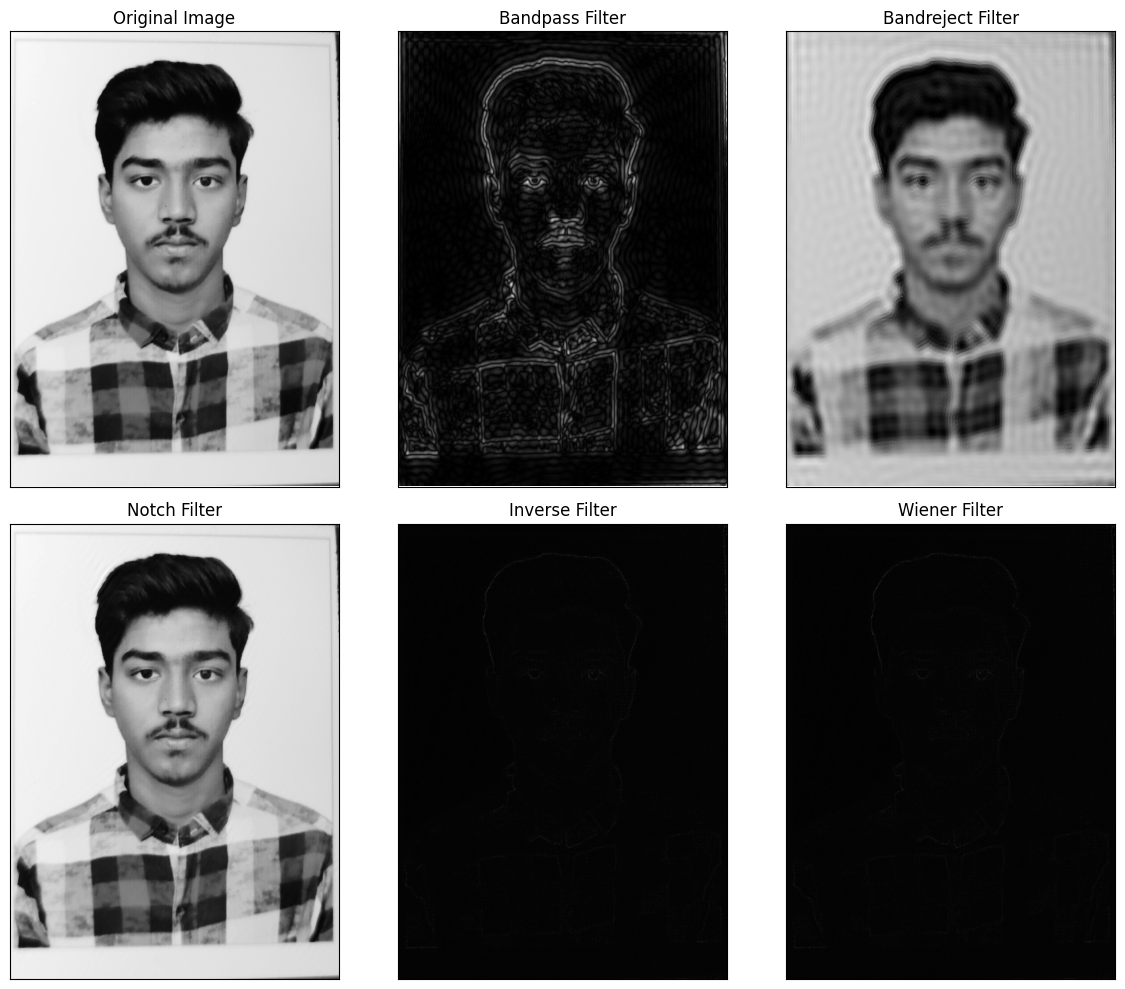

In [35]:

plt.figure(figsize=(12, 10))

plt.subplot(231), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(232), plt.imshow(img_bandpass, cmap='gray')
plt.title('Bandpass Filter'), plt.xticks([]), plt.yticks([])

plt.subplot(233), plt.imshow(img_bandreject, cmap='gray')
plt.title('Bandreject Filter'), plt.xticks([]), plt.yticks([])

plt.subplot(234), plt.imshow(img_notch, cmap='gray')
plt.title('Notch Filter'), plt.xticks([]), plt.yticks([])

plt.subplot(235), plt.imshow(img_inverse, cmap='gray')
plt.title('Inverse Filter'), plt.xticks([]), plt.yticks([])

plt.subplot(236), plt.imshow(img_wiener, cmap='gray')
plt.title('Wiener Filter'), plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()
